In [1]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install labelme

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 4.1 MB/s 
     |████████████████████████████████| 7.7 MB 31.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 82 kB 685 kB/s 
     |████████████████████████████████| 8.4 MB 41.3 MB/s 
     |████████████████████████████████| 59.9 MB 1.2 MB/s 
     |████████████████████████████████| 344 kB 51.6 MB/s 
  Created wheel for labelme: filename=labelme-5.0.5-py3-none-any.whl size=1466328 sha256=1e630ae7b6099d0fe3ee96c867520599fbfe64c3d359c3ca2470c13693f490ad
  Stored in directory: /root/.cache/pip/wheels/49/40/cd/725669fac4476235cb12b1ccce7dbe9acbbf7298047100d1d4
  Created wheel for imgviz: filename=imgviz-1.5.1-py3-none-any.whl size=7680505 sha256=7b2d4a33a2aa7c3d62c314a5e016b010f1abe29cf0412feedc17f79191996f97
  Stored in direc

In [3]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter
import PIL
from PIL import Image
import numpy as np
import pandas as pd
from labelme import utils
from scipy import ndimage, signal
from skimage import io, transform, morphology, feature, measure
import math
import glob
import csv

In [4]:
# set directory for reading image stacks
# img_dir = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6/C6_tiles_withAnnot' 
img_dir = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1' 

In [5]:
img_dir = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1' 
for root, dirs, files in os.walk(img_dir):
    for dir in dirs:
      print(dir)

11136x_36400y
15312x_30160y
12528x_4160y
13920x_64480y
12528x_66560y
16704x_18720y
16704x_52000y
20880x_80080y
19488x_54080y
18096x_7280y
20880x_9360y
19488x_3120y
20880x_50960y
22272x_5200y
23664x_88400y
23664x_86320y
26448x_18720y
25056x_15600y
26448x_23920y
23664x_66560y
26448x_75920y
26448x_31200y
26448x_7280y
27840x_61360y
27840x_57200y
27840x_60320y
27840x_80080y
27840x_12480y
27840x_3120y
29232x_58240y
30624x_56160y
30624x_70720y
29232x_66560y
32016x_19760y
32016x_47840y
33408x_89440y
34800x_49920y
33408x_23920y
32016x_58240y
34800x_75920y
33408x_39520y
34800x_85280y
36192x_23920y
36192x_21840y
37584x_68640y
38976x_58240y
37584x_50960y
36192x_22880y
36192x_64480y
41760x_62400y
40368x_63440y
41760x_76960y
43152x_33280y
40368x_44720y
40368x_60320y
40368x_38480y
38976x_59280y
47328x_16640y
43152x_72800y
45936x_9360y
47328x_2080y
44544x_61360y
44544x_68640y
47328x_41600y
47328x_78000y
52896x_19760y
51504x_19760y
47328x_85280y
48720x_15600y
47328x_82160y
50112x_53040y
51504x_87360y
5

In [7]:
# set location for saving palynomorph crops
# crop_mask_dir = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6/C6_crop_masks'
crop_mask_dir = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_crop_masks/PAL1999_C3_sample43_slide1'
if not os.path.exists(crop_mask_dir): 
    os.makedirs(crop_mask_dir)
# crop_imgstack_dir = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6/C6_crop_img'
crop_imgstack_dir = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_crop_img/PAL1999_C3_sample43_slide1'
if not os.path.exists(crop_imgstack_dir): 
    os.makedirs(crop_imgstack_dir)

## export crops

In [8]:
idx = 0
for root, dirs, files in os.walk(img_dir):
    for dir in dirs:
        dir_path = os.path.join(root,dir)
        files = os.listdir(dir_path)
        full_annot = []
        label_name_to_value = {"_background_": 0}
        for file in files:
            if file.endswith(".json"):
              with open(os.path.join(dir_path, file), "r",encoding="utf-8") as f:
                  tmpData = json.load(f)            
                  for shape in sorted(tmpData["shapes"], key=lambda x: x["label"]):
                      full_annot.append(shape)
                      label_name = shape["label"]
                      label_name_to_value.update({label_name:1})
                      points = shape['points']
                      shape_type = shape.get('shape_type', None)
                      mask = utils.shape_to_mask(
                          (tmpData['imageHeight'],tmpData['imageWidth']), points, shape_type
                      )

                      # export crop masks
                      xy = [tuple(point) for point in points]
                      (cx, cy), (px, py) = xy
                      d = math.sqrt((cx - px) ** 2 + (cy - py) ** 2)

                      top = max(int(cy - d),0)
                      bottom = min(int(cy + d),mask.shape[0])
                      left = max(int(cx - d),0)
                      right = min(int(cx + d),mask.shape[1])

                      crop_mask = mask[top:bottom, left:right]   
                      x,y = crop_mask.shape                    

                      if x < 250 and y <250:
                          mask_path = os.path.join(crop_mask_dir, 'SM_M', label_name)
                          if not os.path.exists(mask_path): 
                              os.makedirs(mask_path)
                      else:
                          mask_path = os.path.join(crop_mask_dir, 'L', label_name)
                          if not os.path.exists(mask_path): 
                              os.makedirs(mask_path)

                      k=1
                      mask_filename = "{}/{}_{}{}".format(mask_path, dir, k, '.png')
                      while os.path.exists(mask_filename):
                          mask_filename = "{}/{}_{}{}".format(mask_path, dir, k, '.png')
                          k += 1

                      if isinstance(crop_mask, np.ndarray):
                          crop_mask = PIL.Image.fromarray((crop_mask * 255).astype(np.uint8))
                      crop_mask.save(mask_filename)                      
                      

                      # export crop img stack
                      crop_stack = []
                      for file in sorted(os.listdir(str(dir_path))):
                          if file.endswith('.png'):
                            tile = os.path.join(str(dir_path), file)
                            crop =  PIL.Image.open(tile)
                            crop = np.array(crop)[top:bottom, left:right]
                            crop_stack.append(crop)

                      img_path = os.path.join(crop_imgstack_dir,label_name)
                      if x < 250 and y <250:
                          img_path = os.path.join(crop_imgstack_dir, 'SM_M', label_name)
                          if not os.path.exists(img_path): 
                              os.makedirs(img_path)
                      else:
                          img_path = os.path.join(crop_imgstack_dir, 'L', label_name)
                          if not os.path.exists(img_path): 
                              os.makedirs(img_path)

                      k = 1
                      img_path_2 = os.path.join(img_path, dir + '_' + str(k))
                      while os.path.exists(img_path_2):
                          img_path_2 = os.path.join(img_path, dir + '_' + str(k))
                          k += 1

                      for m in range(len(crop_stack)):
                          if not os.path.exists(img_path_2): 
                              os.makedirs(img_path_2)             
                          img_filename = "{}/{}{}".format(img_path_2,'tile' + str(m),'.png')

                          if isinstance(crop_stack[m], np.ndarray):
                              img_slice = PIL.Image.fromarray(crop_stack[m])
                          img_slice.save(img_filename)

                      # save an annotation file with the crop stack for easy reference later
                      shape.update({'path_name':dir_path})
                      json_outfile = os.path.join(img_path_2, 'annot.json')
                      with open(json_outfile, 'w', encoding='utf-8') as f:
                          json.dump(shape, f, ensure_ascii=False, indent=4)
                      
                      f.close()

        idx += 1
        print(idx, os.path.join(dir_path))

## uncomment below section if you want the loop to stop at a certain index
        # if idx == 1:
        #   break

1 /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1/11136x_36400y
2 /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1/15312x_30160y
3 /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1/12528x_4160y
4 /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1/13920x_64480y
5 /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1/12528x_66560y
6 /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1/16704x_18720y
7 /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1/16704x_52000y
8 /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1/20880x_80080y
9 /content/gdrive

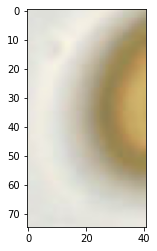

In [ ]:
plt.imshow(crop_stack[2])

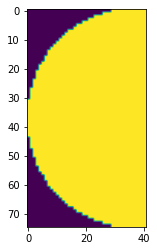

In [ ]:
plt.imshow(crop_mask)

# check annotations (one example)

In [ ]:
print(crop_imgstack_dir)

/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6_crop_img


In [ ]:
# idx = 0
annot_list = glob.glob(os.path.join(crop_imgstack_dir,'*','*','*.json'))
annot_list_SPO = glob.glob(os.path.join(crop_imgstack_dir,'spo','*','*.json'))
for i in annot_list_SPO:
  annot_list.remove(i)
id_list = []

# for i in range(len(annot_list)):
#   print(os.path.dirname(annot_list[i]))

['/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6_crop_img/spo/41392x_42080y_1/annot.json']
28


In [ ]:
def padding(array, xx, yy, zz):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]
    z = array.shape[2]

    a = max((xx - h) // 2,0)
    aa = max(xx - a - h,0)

    b = max((yy - w) // 2,0)
    bb = max(yy - b - w,0)

    c = max((zz - z) // 2,0)
    cc = max(zz - c - z,0)

    return np.pad(array, pad_width=((a, aa), (b, bb),(c,cc)), mode='constant', constant_values = (211,211))

In [ ]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [ ]:
for idx, i in enumerate(chunker(range(0,len(annot_list)), 10)):
  print(idx,i)

0 range(0, 10)
1 range(10, 20)
2 range(20, 29)


In [ ]:

for idx, chunk in enumerate(chunker(range(0,len(annot_list)), 10)):
    ten_crop_stacks = []
    ten_id = []
    crop_imgstack_basenames = []

    for j in chunk:
        crop_imgstack_path = os.path.dirname(annot_list[j])
        crop_paths = glob.glob(os.path.join(crop_imgstack_path,'*.png'))
        crop_imgstack_basename = os.path.basename(crop_imgstack_path)
        crop_imgstack_basenames.append(crop_imgstack_basename)
        id = os.path.basename(os.path.dirname(os.path.dirname(annot_list[j])))
        if id == 'spo':
            continue
      
        #### make a list of crop arrays
        crops = []
        for n, crop in enumerate(crop_paths):
          tmpImg = Image.open(crop)
          tmpImg = np.array(tmpImg)
          crops.append(tmpImg)

        ### add a scaled image array to the list too
        x,y,z = tmpImg.shape
        if x < 301:
            tmpImg = padding(crops[4], 250, 250,3)
        else:
            tmpImg = padding(crops[4], 500, 500,3)
        crops.append(tmpImg)

        ### print tilestack path
        with open(annot_list[j], "r",encoding="utf-8") as f:
          tmpData = json.load(f)
          orig_tilestack_path = tmpData['path_name']
          print(orig_tilestack_path)
        
        ### make lists of 10 crop stacks and their ID's
        ten_crop_stacks.append(crops)
        ten_id.append(id)

    if idx == 0:   
      break

    # if id =='pla':
    #     break

/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6_tiles_withAnnot/40000x_43120y
/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6_tiles_withAnnot/41392x_44160y
/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6_tiles_withAnnot/41392x_41040y
/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6_tiles_withAnnot/41392x_40000y
/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6_tiles_withAnnot/41392x_40000y
/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6_tiles_withAnnot/41392x_47280y
/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6_tiles_withAnnot/40000x_43120y
/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6_tiles_withAnnot/40000x_50400y
/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6_tiles_withAnnot/40000x_49360y
/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6_tiles_withAnnot/40000x_57680y


In [ ]:
# check
print(crop_imgstack_basenames)

['40000x_43120y_1', '41392x_44160y_1', '41392x_41040y_1', '41392x_40000y_1', '41392x_40000y_2', '41392x_47280y_1', '40000x_43120y_1', '40000x_50400y_1', '40000x_49360y_1', '40000x_57680y_1']


In [ ]:
# check, make a dictionary for easy reference at the next step
ten_crop_stacks_dict = {}
for i in range(len(ten_crop_stacks)):
    tmpCropStack = ten_crop_stacks[i]
    tmpCropStack_name = 'cropstack{}'.format(i+1)
    ten_crop_stacks_dict[tmpCropStack_name] = tmpCropStack

for key in ten_crop_stacks_dict:
  print(key)

cropstack1
cropstack2
cropstack3
cropstack4
cropstack5
cropstack6
cropstack7
cropstack8
cropstack9
cropstack10


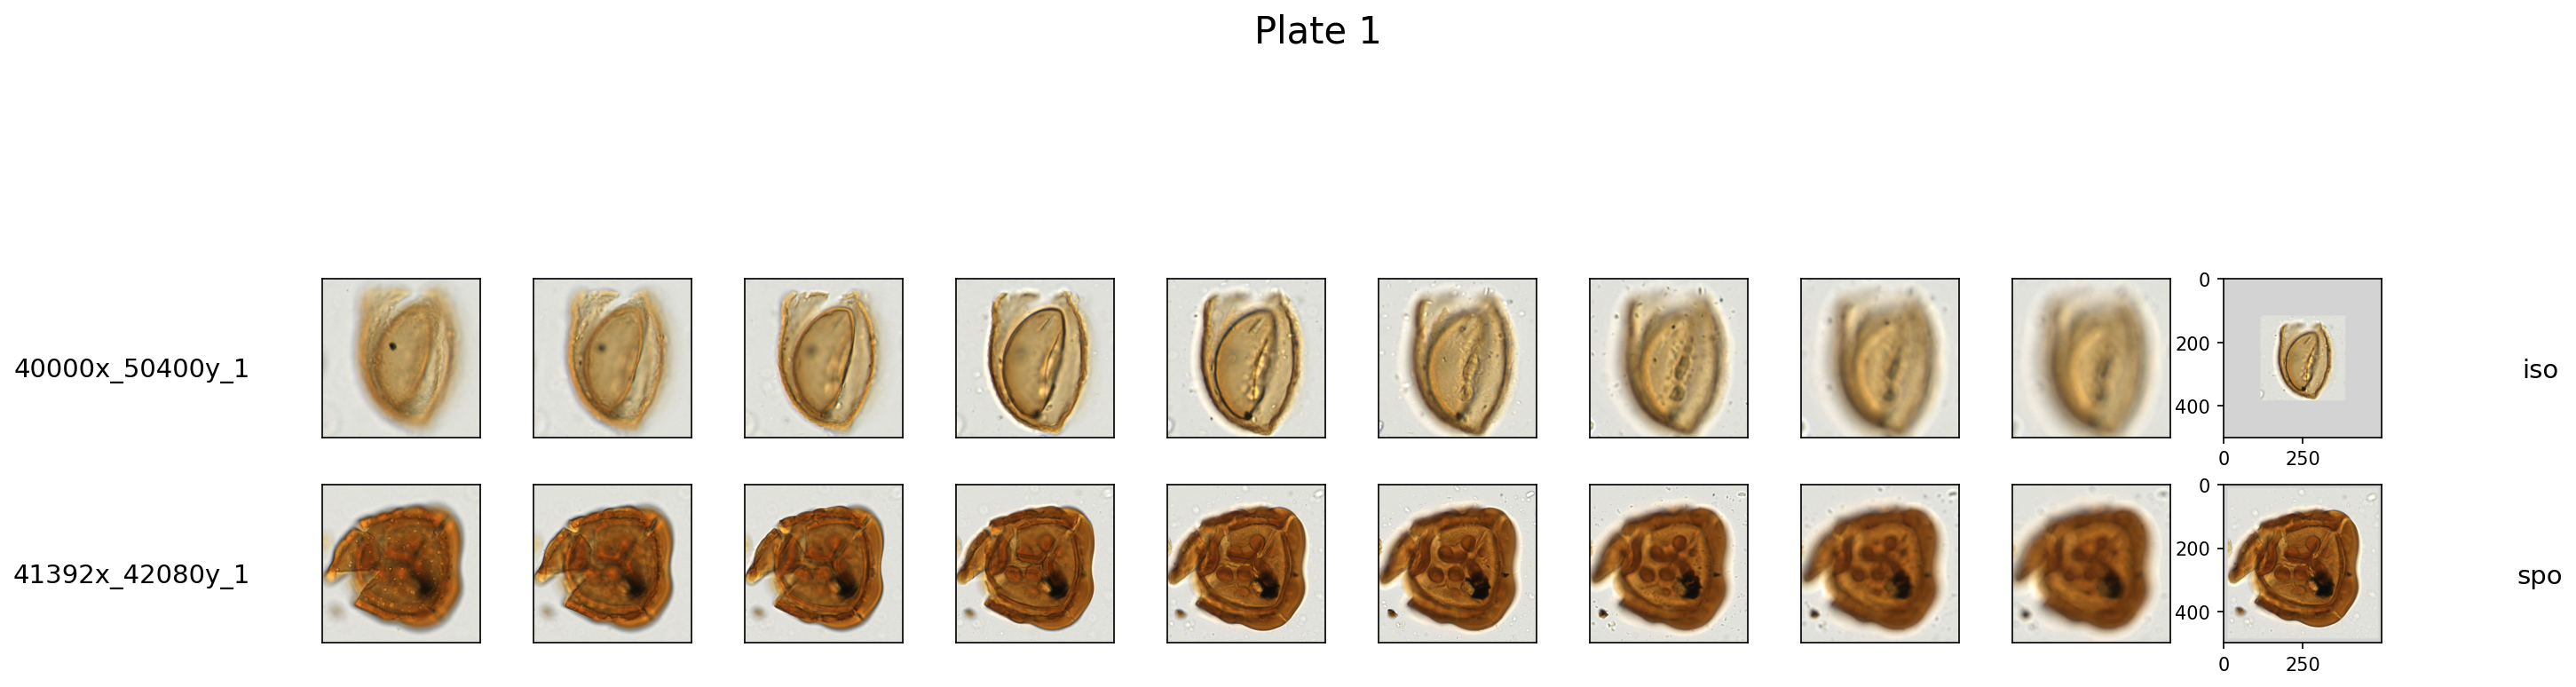

In [ ]:
# create image plate

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20,20), dpi = 150)
fig.suptitle('Plate {idx}'.format(idx = idx +1), fontsize = 20)

outer = gridspec.GridSpec(10, 1, wspace=0.2, hspace=0.3)

for n, key in enumerate(ten_crop_stacks_dict):
    # loop through crops and keep track of index
    tmpCropStack = ten_crop_stacks_dict[key]
    id = str(ten_id[n])
    # plt.suptitle(str(id), fontsize=18)
    inner = gridspec.GridSpecFromSubplotSpec(1, 10,
                subplot_spec=outer[n], wspace=0.3, hspace=0.3)
    
    for m, crop in enumerate(tmpCropStack):
        # create subplot        
        ax = plt.Subplot(fig, inner[m])
        if m == 0:
          ax.set_xlabel(crop_imgstack_basenames[n], fontsize = 14)
          ax.xaxis.set_label_coords(-1.2, 0.5)
        if m != 9:
          ax.set_xticks([])
          ax.set_yticks([])
        if m == 9:
          ax.set_xlabel(id, fontsize = 14)
          ax.xaxis.set_label_coords(2, 0.5)

        # show crop
        ax.imshow(crop)

        # turn axes off and add title
        # ax.set_xticks([])
        # ax.set_yticks([])
        # plt.axis('off')

        fig.add_subplot(ax)

fig.show()

In [ ]:
# set save location

plate_dir = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6_plates'
if not os.path.exists(plate_dir): 
    os.makedirs(plate_dir)

In [ ]:
# export figure

fig.savefig(os.path.join(plate_dir, 'test.pdf'), dpi=150)

# Export plates

In [9]:
## set save location for plates

# plate_dir = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6/C6_plates2'
plate_dir = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_plates2/PAL1999_C3_sample43_slide1'
if not os.path.exists(plate_dir): 
    os.makedirs(plate_dir)

In [10]:
annot_lists = []
annot_list_SM_M = sorted(glob.glob(os.path.join(crop_imgstack_dir,'SM_M','*','*','*.json')))
annot_list_L = sorted(glob.glob(os.path.join(crop_imgstack_dir,'L','*','*','*.json')))

annot_lists.append(annot_list_SM_M)
annot_lists.append(annot_list_L)

In [11]:
print(annot_list_SM_M)

['/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_crop_img/PAL1999_C3_sample43_slide1/SM_M/T1/20880x_50960y_1/annot.json', '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_crop_img/PAL1999_C3_sample43_slide1/SM_M/T1/27840x_60320y_1/annot.json', '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_crop_img/PAL1999_C3_sample43_slide1/SM_M/T1/30624x_56160y_1/annot.json', '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_crop_img/PAL1999_C3_sample43_slide1/SM_M/T2/32016x_19760y_1/annot.json', '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_crop_img/PAL1999_C3_sample43_slide1/SM_M/T3/37584x_50960y_1/annot.json', '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_crop_img/PAL1999_C3_sample43_slide1/SM_M/T3/44544x_40560y_1/annot.json', '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_crop_img/PAL1999_C3_sample43_slide1/SM_M/aca?/79344x_58240y_1/annot.json', '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_crop_img/PAL1999_C3_sample43_s

In [12]:
## Set the microscope resolution here (microns/pixel). This will be used to set the axis labels of the re-scaled image
resolution = 0.22507314877335133

def calibration(x, pos):
    return f'{(x * resolution):.0f}'

formatter = FuncFormatter(calibration)

In [13]:
def padding(array, xx, yy, zz):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]
    z = array.shape[2]

    a = max((xx - h) // 2,0)
    aa = max(xx - a - h,0)

    b = max((yy - w) // 2,0)
    bb = max(yy - b - w,0)

    c = max((zz - z) // 2,0)
    cc = max(zz - c - z,0)

    return np.pad(array, pad_width=((a, aa), (b, bb),(c,cc)), mode='constant', constant_values = (211,211))

In [14]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [15]:
dataframe = []

for annot_list in annot_lists:
    for idx, chunk in enumerate(chunker(range(0,len(annot_list)), 10)):
        ten_crop_stacks = []
        ten_id = []
        crop_imgstack_basenames = []

        for j in chunk:
            crop_imgstack_path = os.path.dirname(annot_list[j])
            crop_paths = glob.glob(os.path.join(crop_imgstack_path,'*.png'))
            crop_imgstack_basename = os.path.basename(crop_imgstack_path)
            crop_imgstack_basenames.append(crop_imgstack_basename)
            id = os.path.basename(os.path.dirname(os.path.dirname(annot_list[j])))
            size_class = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(annot_list[j]))))
            if size_class == 'SM_M':
              size_class_name = 'Small Medium Grains'
            else:
                size_class_name = 'Oversized Grains'
            plate_name = 'Plate {idx} - {size}'.format(idx = idx+1, size = size_class_name)
            with open(annot_list[j], "r",encoding="utf-8") as f:
              tmpData = json.load(f)
              points = tmpData['points']

            data = [plate_name, crop_imgstack_basename, id, points, '','','','','','']
            dataframe.append(data)

            ### make a list of crop arrays
            crops = []
            for n, crop in enumerate(crop_paths):
              tmpImg = Image.open(crop)
              tmpImg = np.array(tmpImg)
              crops.append(tmpImg)

            ### add a scaled image array to the list too
            x,y,z = tmpImg.shape
            if x < 250 and y <250:
                tmpImg = padding(crops[4], 250, 250,3)
            else:
                tmpImg = padding(crops[4], 500, 500,3)
            crops.append(tmpImg)

            ### print tilestack path
            with open(annot_list[j], "r",encoding="utf-8") as f:
              tmpData = json.load(f)
              orig_tilestack_path = tmpData['path_name']
              print(orig_tilestack_path)
            
            ### make lists of 10 crop stacks and their ID's
            ten_crop_stacks.append(crops)
            ten_id.append(id)

            # check, make a dictionary for easy reference at the next step
            ten_crop_stacks_dict = {}
            for i in range(len(ten_crop_stacks)):
                tmpCropStack = ten_crop_stacks[i]
                tmpCropStack_name = 'cropstack{}'.format(i+1)
                ten_crop_stacks_dict[tmpCropStack_name] = tmpCropStack


    ######### make plate #####################################################
        fig = plt.figure(figsize=(20,20), dpi = 150)
        fig.suptitle(plate_name, fontsize = 20)

        outer = gridspec.GridSpec(10, 1, wspace=0.2, hspace=0.3)

        for n, key in enumerate(ten_crop_stacks_dict):
            # loop through crops and keep track of index
            tmpCropStack = ten_crop_stacks_dict[key]
            id = str(ten_id[n])
            # plt.suptitle(str(id), fontsize=18)
            inner = gridspec.GridSpecFromSubplotSpec(1, 10,
                        subplot_spec=outer[n], wspace=0.3, hspace=0.3)
            
            for m, crop in enumerate(tmpCropStack):
                # create subplot        
                ax = plt.Subplot(fig, inner[m])
                if m == 0:
                  ax.set_xlabel(crop_imgstack_basenames[n], fontsize = 14)
                  ax.xaxis.set_label_coords(-1, 0.5)
                if m != 9:
                  ax.set_xticks([])
                  ax.set_yticks([])
                if m == 9:
                  ax.set_xlabel(id, fontsize = 14)
                  ax.xaxis.set_label_coords(2, 0.5)
                  ax.xaxis.set_major_formatter(formatter)
                  ax.yaxis.set_major_formatter(formatter)    
                  ten_micron_interval = 10/resolution
                  twenty_micron_interval = 20/resolution
                  if crop.shape[0] < 251 and crop.shape[1] < 251:
                      ax.set_xticks(np.arange(0, crop.shape[0]+1, ten_micron_interval))
                      ax.set_yticks(np.arange(0, crop.shape[1]+1, ten_micron_interval))      
                  else:         
                      ax.set_xticks(np.arange(0, crop.shape[0]+1, twenty_micron_interval))
                      ax.set_yticks(np.arange(0, crop.shape[1]+1, twenty_micron_interval)) 

                # show crop
                ax.imshow(crop)

                fig.add_subplot(ax)

        fig.show()
        fig.savefig(os.path.join(plate_dir, 'Plate_' + str(idx+1) + '_' + size_class +'.pdf'), dpi=150)
        plt.close(fig)


header = ['Plate', 'Stack ID', 'Taxon_Code', 'Coords', 'User1','User1_check', 'User1_notes', 'User2', 'User2_check','User2_notes']
df = pd.DataFrame(dataframe, columns=header)
df.to_csv(os.path.join(plate_dir,'Annot_check.csv'), sep=',', index=False)
    # if idx == 0:   
    #   break

/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1/20880x_50960y
/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1/27840x_60320y
/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1/30624x_56160y
/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1/32016x_19760y
/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1/37584x_50960y
/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1/44544x_40560y
/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1/79344x_58240y
/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot_2slides/PAL1999_C3_sample43_slide1/16704x_52000y
/content/gdrive/MyDrive/UTRECHT/

In [ ]:
print(df)

                            Plate         Stack ID taxon code User1  \
0   Plate 1 - Small Medium Grains  40000x_59760y_1        cec         
1   Plate 1 - Small Medium Grains  41392x_48320y_1        gun         
2   Plate 1 - Small Medium Grains  41392x_40000y_1        ind         
3   Plate 1 - Small Medium Grains  40000x_43120y_1        iso         
4   Plate 1 - Small Medium Grains  40000x_49360y_1        iso         
5   Plate 1 - Small Medium Grains  40000x_57680y_1        iso         
6   Plate 1 - Small Medium Grains  40000x_57680y_2        iso         
7   Plate 1 - Small Medium Grains  40000x_57680y_3        iso         
8   Plate 1 - Small Medium Grains  40000x_57680y_4        iso         
9   Plate 1 - Small Medium Grains  41392x_45200y_1        iso         
10  Plate 2 - Small Medium Grains  40000x_45200y_1        lyc         
11  Plate 2 - Small Medium Grains  41392x_48320y_1        lyc         
12  Plate 2 - Small Medium Grains  41392x_48320y_2        lyc         
13  Pl

# create spreadsheet to record annotations

9


In [ ]:
tmpData.update({'user': 'Jen'})          # add username
tmpData.update({'validated': 1})         # 1 = validated, 0 = not validated
tmpData.update({'label_update': ''})  # (optional) updated label
tmpData.update({'notes': ''}) 

In [ ]:
print("{}: {}".format('user', tmpData['user']))
print("{}: {}".format('validated', tmpData['validated']))
print("{}: {}".format('label_update', tmpData['label_update']))
print("{}: {}".format('notes', tmpData['notes']))

user: Jen
validated: 1
label_update: 
notes: 


In [ ]:
# make a dataframe of files, IDs, 